In [ ]:
import os
import time
import json

import h5py
import keras
import numpy as np
import pandas as pd
import seaborn as sb
import tensorflow as tf
import matplotlib.pyplot as plt

from PIL import Image
from keras.optimizers import Adam
from keras.utils import plot_model
from matplotlib.image import imread
from keras.preprocessing import image
from mixup_generator import MixupGenerator
from random_eraser import get_random_eraser 
from keras.models import Sequential, load_model
from keras.losses import CategoricalCrossentropy
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB3
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, StratifiedKFold
from keras.layers import GlobalAveragePooling2D, Flatten, Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Dados

## Explorando dados

In [ ]:
# Importando csv do dataset
data = pd.read_csv('drive/MyDrive/CassavaLeafDisease/dados/train.csv', sep = ',')
data.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [ ]:
# Lendo json e crinado mapping para para classe
with open('drive/MyDrive/CassavaLeafDisease/dados/label_num_to_disease_map.json') as f:
    mapping = json.loads(f.read())
    mapping = {int(k): v for k, v in mapping.items()}

mapping

{0: 'Cassava Bacterial Blight (CBB)',
 1: 'Cassava Brown Streak Disease (CBSD)',
 2: 'Cassava Green Mottle (CGM)',
 3: 'Cassava Mosaic Disease (CMD)',
 4: 'Healthy'}

In [ ]:
# Adicionando label_name ao conjunto de dados, e ondenando colunas
data['label_name'] = data['label'].map(mapping)
data = data[['image_id', 'label_name', 'label']]

In [ ]:
data.head()

,image_id,label_name,label
0,1000015157.jpg,Cassava Bacterial Blight (CBB),0
1,1000201771.jpg,Cassava Mosaic Disease (CMD),3
2,100042118.jpg,Cassava Brown Streak Disease (CBSD),1
3,1000723321.jpg,Cassava Brown Streak Disease (CBSD),1
4,1000812911.jpg,Cassava Mosaic Disease (CMD),3


In [ ]:
# Verificando frequencia
data.label_name.value_counts()

Cassava Mosaic Disease (CMD)           13158
Healthy                                 2577
Cassava Green Mottle (CGM)              2386
Cassava Brown Streak Disease (CBSD)     2189
Cassava Bacterial Blight (CBB)          1087
Name: label_name, dtype: int64

In [ ]:
# Verificando proporção 
data.label_name.value_counts(normalize = True) * 100

Cassava Mosaic Disease (CMD)           61.494602
Healthy                                12.043744
Cassava Green Mottle (CGM)             11.151096
Cassava Brown Streak Disease (CBSD)    10.230406
Cassava Bacterial Blight (CBB)          5.080151
Name: label_name, dtype: float64

# Preparando os dados

## HoldOut
Separando dados de treino e teste

In [ ]:
# Definindo paths de treino e teste
TRAIN_PATH = 'drive/MyDrive/CassavaLeafDisease/dados/train_images/'
TEST_PATH = 'drive/MyDrive/CassavaLeafDisease/dados/test_images/'
IMAGE_TEST = 'drive/MyDrive/CassavaLeafDisease/dados/test_images/2216849948.jpg'

In [ ]:
# Criando amostra para treino e teste estrafiticada
train, test = train_test_split(data, test_size = 0.30, shuffle = True, random_state = 0, stratify = data['label_name'])

In [ ]:
# Verificando frequencia do conjunto de trian
train.label_name.value_counts()

Cassava Mosaic Disease (CMD)           9210
Healthy                                1804
Cassava Green Mottle (CGM)             1670
Cassava Brown Streak Disease (CBSD)    1532
Cassava Bacterial Blight (CBB)          761
Name: label_name, dtype: int64

In [ ]:
train.shape

(14977, 3)

In [ ]:
# Verificando frequencia do conjunto de test
test.label_name.value_counts()

Cassava Mosaic Disease (CMD)           3948
Healthy                                 773
Cassava Green Mottle (CGM)              716
Cassava Brown Streak Disease (CBSD)     657
Cassava Bacterial Blight (CBB)          326
Name: label_name, dtype: int64

In [ ]:
test.shape

(6420, 3)

In [ ]:
# Criando conjunto de dados de validação
index = (test.shape[0] - int(test.shape[0] * 0.10))
valid = test.iloc[index:, :]
test = test.iloc[:index, :]
valid.shape, test.shape

((642, 3), (5778, 3))

## HDF5 
Hierarchical Data Format 5 é um formato de dados binários poderoso sem limite máximo para o tamanho do arquivo. Ele fornece IO paralelo e realiza várias otimizações de baixo nível para tornar as consultas mais rápidas e os requisitos de armazenamento menores.

In [ ]:
'''
Criando matrizes(ndarray) com imagens redimencionadas de 800x600 para 200x200 a parti do path de terino, usando o split 70% para treino, 20% para teste e 10% para validação. Será gerado as matrizes com shape (?, 200, 200, 3).
'''
image_x_train = []
image_y_train = train.label.values
image_y_train = keras.utils.to_categorical(image_y_train, 5)

def image_train (x):
    img = image.load_img(TRAIN_PATH + x, target_size = (200, 200))
    img = image.img_to_array(img)
    image_x_train.append(img)


image_x_test = []
image_y_test = test.label.values
image_y_test = keras.utils.to_categorical(image_y_test, 5)

def image_test (x):
    img = image.load_img(TRAIN_PATH + x, target_size = (200, 200))
    img = image.img_to_array(img)
    image_x_test.append(img)


image_x_valid = []
image_y_valid = valid.label.values
image_y_valid = keras.utils.to_categorical(image_y_valid, 5)

def image_valid (x):
    img = image.load_img(TRAIN_PATH + x, target_size = (200, 200))
    img = image.img_to_array(img)
    image_x_valid.append(img)

In [ ]:
test['image_id'].map(image_test)

6396     None
14910    None
9452     None
3104     None
3045     None
         ... 
14792    None
5518     None
15810    None
17639    None
2213     None
Name: image_id, Length: 5778, dtype: object

In [ ]:
# Criando conjunto de test hdf5
with h5py.File('dados/test.h5', 'w') as hf:
    hf.create_dataset('image_x_test', dtype = 'uint8', data = image_x_test)
    hf.create_dataset('image_y_test', dtype = 'uint8', data = image_y_test)

In [ ]:
train['image_id'].map(image_train)

15787    None
17225    None
7087     None
17283    None
18111    None
         ... 
4653     None
7802     None
11964    None
6846     None
17678    None
Name: image_id, Length: 14977, dtype: object

In [ ]:
# Crinado conjunto de treino hdf5
with h5py.File('dados/train.h5', 'w') as hf:
    hf.create_dataset('image_x_train', dtype = 'uint8', data = image_x_train)
    hf.create_dataset('image_y_train', dtype = 'uint8', data = image_y_train)

In [ ]:
valid['image_id'].map(image_valid)

6986     None
14007    None
1831     None
19138    None
1819     None
         ... 
20441    None
5036     None
18923    None
19799    None
3296     None
Name: image_id, Length: 642, dtype: object

In [ ]:
# Crinado conjunto de validação hdf5
with h5py.File('dados/valid.h5', 'w') as hf:
    hf.create_dataset('image_x_valid', dtype = 'uint8', data = image_x_valid)
    hf.create_dataset('image_y_valid', dtype = 'uint8', data = image_y_valid)

## Tratamento das imagens
Nossas imagens não estão no formato adequado para usarmos em uma rede neural, usaremos a classe **ImageDataGenerator** com o method **flow_from_dataframe** do keras. Ele irar percorrer nosso cvs e diretório de dados, carregando os dados de imagem e retornar a entrada (matrizes de pixels) e a saída (número inteiro de classe).

## Data Augumentation

É uma técnica para gerar novos exemplares de dados de treinamento a fim de aumentar a generalidade do modelo. Técnicas de aumento de dados, como corte, preenchimento, redimensionamento e rotação, são comumente usadas para treinar grandes redes neurais.

A ideia de manipular imagens decorre de uma premissa básica das atividades que envolvem Deep Learning e a Aprendizagem de Máquina, que é a representatividade da amostra de dados utilizada para treinar um modelo. Quanto maior for a amostra e mais representativos forem os dados utilizados na etapa de treinamento, melhor será o desempenho do modelo ao classificar novos dados. Assim, ao rotacionar as imagens e redimensiona-las, aumentamos nosso espaço amostral gerando uma maior variabilidade de dados, fazendo com que nosso modelo aprenda características apresentadas sob outra "forma".

### Definindo parâmetros para tratamnetos das imagens
Abaixo estamos aumentando nossos dados ao gerar novas imagens a partir das imagens já existentes. Cada parâmetro passado a nossa classe **ImageDataGenerator** altera características das imagens existentes, como zoom, largura, rotação, escala e etc. Um exemplo pode ser visto nas imagens abaixo.

In [ ]:
train_generator = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
    #preprocessing_function = get_random_eraser(v_l = 0, v_h = 255),
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    vertical_flip = True,
    fill_mode = 'nearest',
    #rescale = 1. / 255
)

test_generator = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
    #rescale = 1. / 255
)

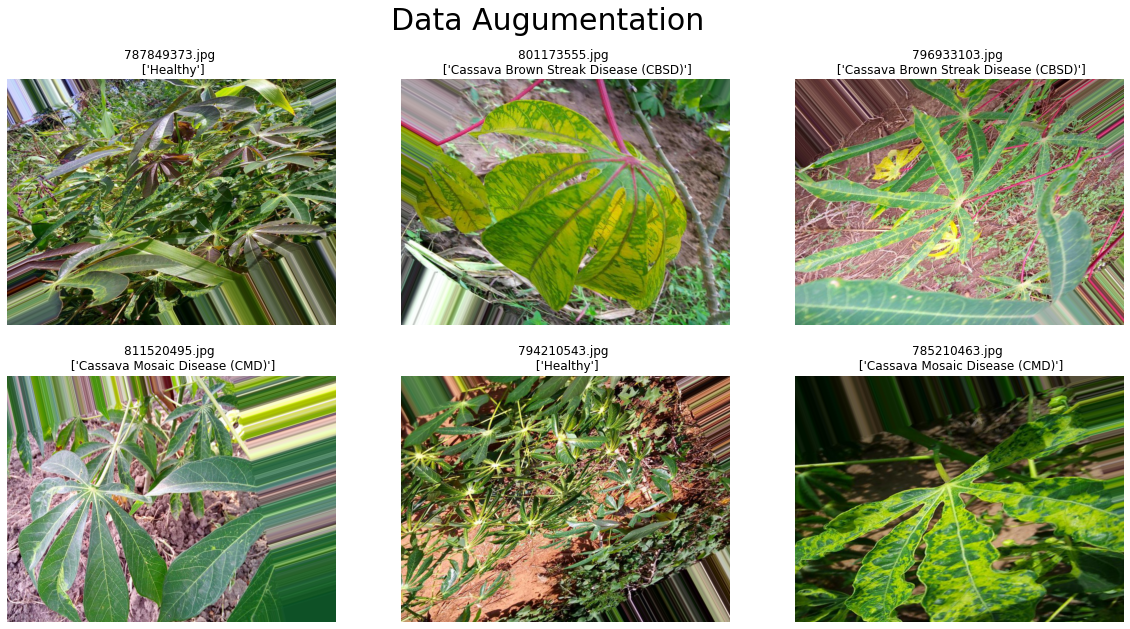

In [ ]:
# Plotando imagens com aumento usando ImageDataGenerator do keras
image_list = os.listdir(TRAIN_PATH)
count = 0

plt.figure(figsize = (20, 10))
for i in image_list:
    img = imread(TRAIN_PATH + i)
    plt.subplot(2, 3, count + 1)
    plt.suptitle("Data Augumentation", fontsize = 30)
    plt.imshow(train_generator.random_transform(img))
    plt.title(f"{i} \n {data.loc[data.image_id == i, 'label_name'].values}")
    plt.axis('off')
    count += 1
    if(count == 6):
        break

## MixUp

In [ ]:
# Carregando arquivo hdf5 de test
with h5py.File('drive/MyDrive/CassavaLeafDisease/dados/test.h5', 'r') as f:
    mixup_x_test = f['image_x_test'][:]
    mixup_y_test = f['image_y_test'][:]

#mixup_x_test = mixup_x_test.astype('float32')
#mixup_x_test /= 255

In [ ]:
# Carregando arquivo hdf5 de train
with h5py.File('drive/MyDrive/CassavaLeafDisease/dados/train.h5', 'r') as h:
    mixup_x_train = h['image_x_train'][:]
    mixup_y_train = h['image_y_train'][:]

#mixup_x_train = mixup_x_train.astype('float32')
#mixup_x_train /= 255

In [ ]:
# Carregando arquivo hdf5 de valid
with h5py.File('drive/MyDrive/CassavaLeafDisease/dados/valid.h5', 'r') as h:
    mixup_x_valid = h['image_x_valid'][:]
    mixup_y_valid = h['image_y_valid'][:]

#mixup_x_valid = mixup_x_valid.astype('float32')
#mixup_x_valid /= 255

In [ ]:
# Gerando MixUp das imagens junto com ImageDataGenerator do keras 'datagen = train_generator'
mixup_gen = MixupGenerator(mixup_x_train, mixup_y_train, datagen = train_generator, alpha = 0.5)()

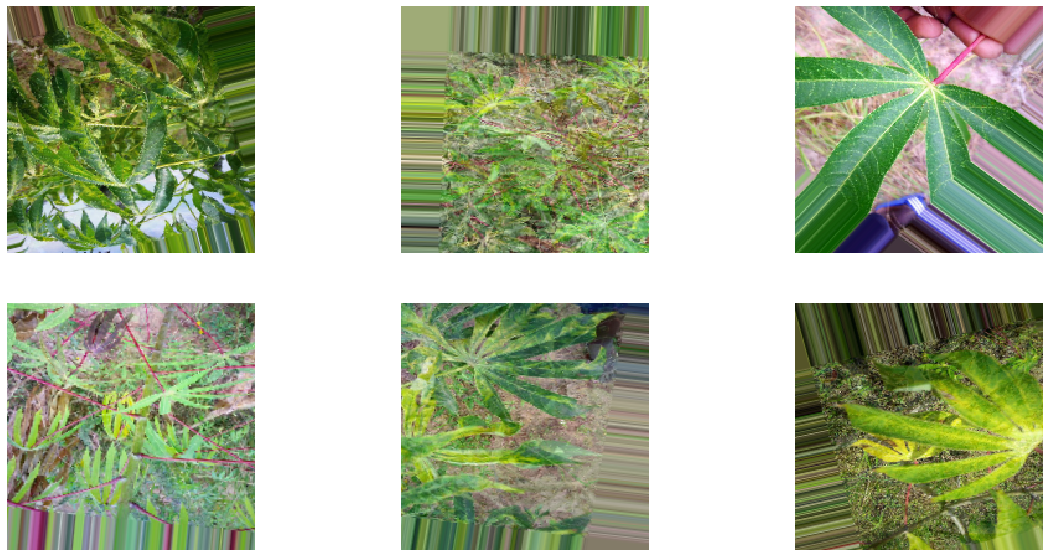

In [ ]:
# Plotando imagens utilizdas no MixupGenerator
x, y = next(mixup_gen)
plt.figure(figsize = (20, 10))

for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(x[i].astype(np.uint8), interpolation = "nearest")
    plt.axis('off')

# Modelo

## Trabalhando hiperparâmetros da rede neural

In [ ]:
# Definindo loss function
loss = CategoricalCrossentropy(from_logits = False, label_smoothing = 0.0001, name = 'categorical_crossentropy')
# Pare de treinar quando o val_loss parar de diminuir por 3 épocas
es = EarlyStopping(monitor = 'val_loss', patience = 3, mode = 'min', restore_best_weights = True, verbose = 1)
# Salve o modelo com o mínimo de perda de validação
checkpoint = ModelCheckpoint(filepath = 'CassavaLeafDiseaseV2.h5', monitor = 'val_loss', save_best_only = True, mode = 'min', verbose = 1)
# Reduza a taxa de aprendizagem quando a aprendizagem estagnar
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 2, min_lr = 1e-6, mode = 'min', verbose = 1)

## EfficientNetB3

In [ ]:
# Criando modelo de rede neural
modelo = Sequential()
modelo.add(EfficientNetB3(input_shape = (200, 200, 3), include_top = False, weights = 'imagenet', drop_connect_rate = 0.6))
modelo.add(GlobalAveragePooling2D())
modelo.add(Flatten())
modelo.add(Dense(256, activation = 'relu', bias_regularizer = tf.keras.regularizers.L1L2(l1 = 0.01, l2 = 0.001)))
modelo.add(Dropout(0.2))
modelo.add(Dense(5, activation = 'softmax'))

In [ ]:
# Bloqueando pesos da EfficientNetB3
modelo.layers[0].trainable = True
set_trainable = False

# Desbloqueando pesos da layer block1a_se_excite em diante
for layer in modelo.layers[0].layers:
    if layer.name == 'block1a_se_excite':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
# Compilando rede neural
modelo.compile(optimizer = Adam(lr = 0.001, decay = 0.0001, clipvalue = 0.5), loss = loss, metrics = ['categorical_accuracy'])

In [ ]:
# Informações de parâmetros do modelo 
modelo.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb3 (Functional)  (None, 7, 7, 1536)        10783535  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1536)              0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1536)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               393472    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 1285      
Total params: 11,178,292
Trainable params: 11,090,989
Non-trainable params: 87,303
_____________________________________

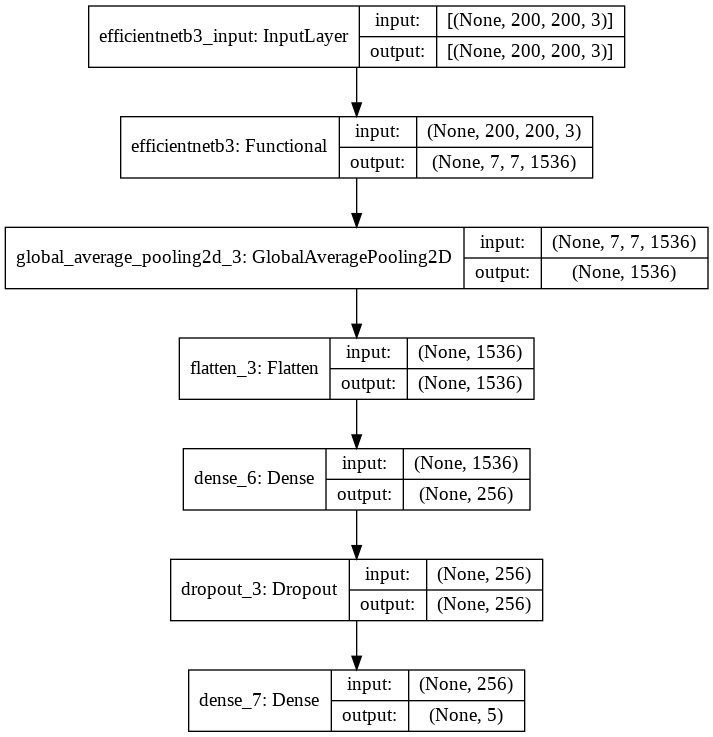

In [ ]:
# Plotando fluxograma do modelo
plot_model(modelo, to_file = 'drive/MyDrive/CassavaLeafDisease/img/modelo.png',  show_shapes = True)

In [ ]:
# Informações de parâmetros do modelo EfficientNetB3
modelo.layers[0].summary()

In [ ]:
# Plotando fluxograma do modelo EfficientNetB3
plot_model(modelo.layers[0], to_file = 'img/efficientnetb3.png',  show_shapes = True)

## Treinamento e Teste usando Data Augumentation, MixUp e Random Eraser

In [ ]:
# Definindo parâmetros para treino e teste
STEP_SIZE_TRAIN = len(mixup_x_train) // 15
STEP_SIZE_TEST = len(mixup_x_test) // 15

# Verificando tempo de execução
inicio = time.time()

# Treinamento e teste do modelo
results = modelo.fit( 
        mixup_gen, 
        validation_data = (mixup_x_test, mixup_y_test), 
        epochs = 30, 
        batch_size = 10, 
        steps_per_epoch = STEP_SIZE_TRAIN,
        validation_steps = STEP_SIZE_TEST, 
        callbacks = [es, checkpoint, reduce_lr]
)

print()
fim = time.time()
print(fim - inicio)
print()

Epoch 1/30
998/998 [==============================] - 425s 426ms/step - loss: 0.8672 - categorical_accuracy: 0.7277 - val_loss: 0.7757 - val_categorical_accuracy: 0.7166

Epoch 00001: val_loss improved from inf to 0.77568, saving model to CassavaLeafDisease-v2.h5
Epoch 2/30
998/998 [==============================] - 425s 426ms/step - loss: 0.7900 - categorical_accuracy: 0.7626 - val_loss: 0.5972 - val_categorical_accuracy: 0.7901

Epoch 00002: val_loss improved from 0.77568 to 0.59718, saving model to CassavaLeafDisease-v2.h5
Epoch 3/30
998/998 [==============================] - 430s 431ms/step - loss: 0.7543 - categorical_accuracy: 0.7814 - val_loss: 0.4962 - val_categorical_accuracy: 0.8255

Epoch 00003: val_loss improved from 0.59718 to 0.49615, saving model to CassavaLeafDisease-v2.h5
Epoch 4/30
998/998 [==============================] - 427s 428ms/step - loss: 0.7348 - categorical_accuracy: 0.7917 - val_loss: 0.4675 - val_categorical_accuracy: 0.8335

Epoch 00004: val_loss improve

In [ ]:
# Salvando modelo
modelo.save('CassavaLeafDiseaseV2.h5')

## Resultados

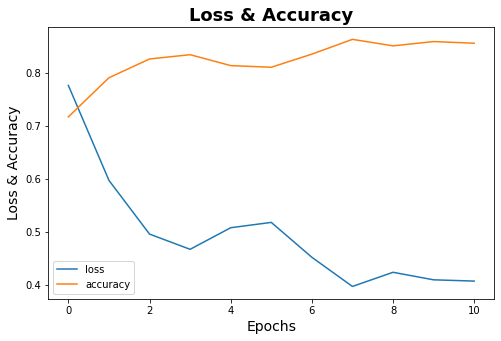

In [ ]:
# Plotando val_loss e val_binary_accuracy do modelo 
plt.figure(figsize = (8, 5))
plt.plot(results.history['val_loss'])
plt.plot(results.history['val_categorical_accuracy'])
plt.title('Loss & Accuracy', fontweight = 'bold', fontsize = 18)
plt.xlabel('Epochs', fontsize = 14)
plt.ylabel('Loss & Accuracy', fontsize = 14)
plt.legend(title = '', labels = ['loss','accuracy'], ncol = 1, loc = 'lower left')

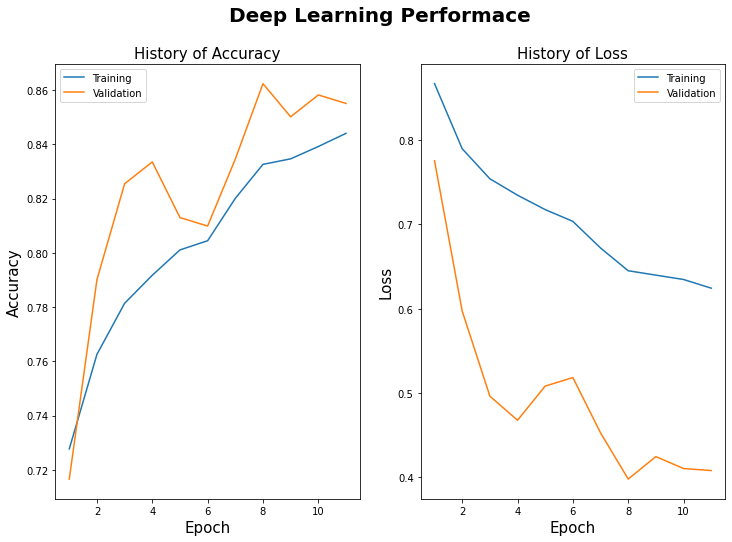

In [ ]:
sca = range(1, len(results.history['categorical_accuracy']) + 1)
sva = range(1, len(results.history['val_categorical_accuracy']) + 1)
slo = range(1, len(results.history['loss']) + 1)
svl = range(1, len(results.history['val_loss']) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 8))
fig.suptitle('Deep Learning Performace', fontweight = 'bold', fontsize = 20)

ax1.plot(sca, results.history['categorical_accuracy'], label = 'Training')
ax1.plot(sva, results.history['val_categorical_accuracy'], label = 'Validation')
ax1.set_title('History of Accuracy', fontsize = 15)
ax1.set_xlabel('Epoch', fontsize = 15)
ax1.set_ylabel('Accuracy', fontsize = 15)
ax1.legend(loc = 'best')

ax2.plot(slo, results.history['loss'], label = 'Training')
ax2.plot(svl, results.history['val_loss'], label = 'Validation')
ax2.set_title('History of Loss', fontsize = 15)
ax2.set_xlabel('Epoch', fontsize = 15)
ax2.set_ylabel('Loss', fontsize = 15)
ax2.legend(loc = 'best')
plt.show()

In [ ]:
# Realisando classificação no conjunto de validação
def validation_test():
    
    valid_generator = ImageDataGenerator(
        preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
        #rescale = 1. / 255
    )    

    valid_set = valid_generator.flow_from_dataframe(
        dataframe = valid,
        directory= TRAIN_PATH,
        seed = 42,
        x_col = 'image_id',
        y_col = 'label_name',
        target_size = (200, 200),
        class_mode = 'categorical',
        interpolation = 'nearest',
        shuffle = True,
        batch_size = 15
    )

    # Accuracy usando keras
    modelo.evaluate(valid_set)

In [ ]:
validation_test()

Found 642 validated image filenames belonging to 5 classes.
43/43 [==============================] - 324s 8s/step - loss: 0.4628 - categorical_accuracy: 0.8411
